# Bob.FM Hardware FIR Filter

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal

In [8]:
def signal_gen(frequency=0.5, amplitude=1, phase_degrees=0, duration=1, Fs=1):
    phase = phase_degrees * np.pi/180
    t  = np.arange(0,duration, 1/Fs) # X axis: Time & Samples
    return amplitude*np.sin(2*np.pi*frequency*t+phase), t

def dB(voltage):
    return 20 * np.log10(voltage)

### Filter Design
This part encapsulates the design decisions of the BOB.FM FIR filter.
            
    Center Frequency (fr): 103.7MHz
    FM Passband: 200kHz
    Stopbands: 0-200Hz and 700-1000Hz.
    Sampling frequency (Fs): 250MHz
    
References: [T-Filt](http://t-filter.engineerjs.com/), [mytexttools](https://mytexttools.com/find-and-replace-text.html)

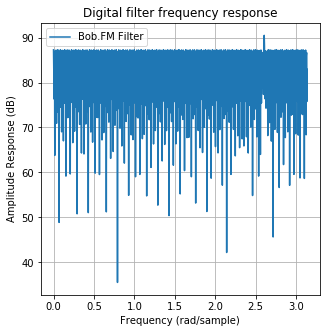

In [6]:
# Filter parameters
fr     = 103.7e6 # Bob.FM station
Fs     = 250e6
nfft   = int(1000)

b = [5724, 8607, -3913, 1623, -662, 420, -516, 693, -789, 725, -493, 149, 216, -506, 644, -600, 391, -81, -240, 485, -589, 526, -321, 34, 253, -460, 534, -459, 260, 5, -259, 434, -483, 398, -206, -37, 261, -407, 435, -343, 159, 63, -260, 380, -391, 294, -119, -83, 256, -353, 350, -250, 85, 99, -250, 327, -312, 211, -56, -113, 238, -309, 269, -182, 31, 126, -230, 275, -249, 148, -5, -128, 220, -253, 219, -122, -10, 134, -213, 231, -188, 95, 21, -131, 203, -216, 167, -73, -38, 134, -190, 192, -143, 56, 45, -131, 180, -178, 126, -40, -56, 133, -171, 161, -106, 23, 63, -130, 159, -143, 89, -12, -67, 126, -149, 131, -76, 2, 72, -124, 142, -117, 65, 10, -76, 121, -133, 104, -49, -18, 81, -118, 121, -93, 39, 26, -82, 113, -113, 83, -29, -32, 82, -108, 104, -73, 21, 37, -84, 106, -98, 63, -12, -43, 86, -104, 94, -58, 7, 44, -81, 95, -82, 46, 3, -52, 85, -94, 76, -38, -10, 54, -84, 89, -70, 32, 15, -58, 84, -86, 64, -26, -21, 59, -83, 82, -59, 21, 25, -62, 81, -79, 54, -14, -29, 63, -80, 74, -47, 8, 33, -65, 78, -70, 42, -3, -37, 67, -77, 66, -37, -3, 42, -69, 76, -61, 30, 9, -46, 70, -73, 57, -24, -14, 49, -70, 72, -53, 20, 19, -52, 71, -69, 49, -15, -24, 55, -71, 67, -44, 9, 28, -57, 71, -64, 40, -4, -32, 59, -70, 60, -35, 0, 35, -61, 69, -58, 31, 5, -39, 62, -68, 55, -26, -9, 42, -64, 67, -52, 22, 15, -47, 66, -66, 48, -16, -20, 51, -68, 65, -45, 13, 23, -52, 68, -63, 41, -7, -29, 56, -69, 61, -37, 2, 33, -59, 69, -59, 33, 2, -37, 61, -69, 56, -29, -7, 41, -63, 68, -52, 23, 13, -45, 65, -68, 51, -20, -16, 48, -66, 66, -47, 15, 22, -52, 67, -64, 42, -9, -26, 55, -68, 62, -39, 5, 31, -58, 69, -61, 35, 0, -35, 60, -70, 59, -32, -4, 40, -64, 71, -57, 28, 9, -44, 67, -71, 55, -24, -15, 49, -69, 71, -52, 19, 20, -53, 72, -70, 49, -14, -24, 57, -73, 70, -46, 9, 30, -61, 76, -69, 42, -3, -37, 66, -77, 67, -37, -3, 42, -70, 78, -65, 33, 8, -47, 74, -80, 63, -29, -14, 54, -79, 81, -62, 25, 21, -59, 82, -83, 59, -21, -26, 64, -86, 84, -58, 15, 32, -70, 89, -84, 54, -10, -38, 76, -94, 85, -52, 3, 46, -82, 95, -81, 44, 7, -58, 94, -104, 86, -43, -12, 63, -98, 106, -84, 37, 21, -73, 104, -108, 82, -32, -29, 83, -113, 113, -82, 26, 39, -93, 121, -118, 81, -18, -49, 104, -133, 121, -76, 10, 65, -117, 142, -124, 72, 2, -76, 131, -149, 126, -67, -12, 89, -143, 159, -130, 63, 23, -106, 161, -171, 133, -56, -40, 126, -178, 180, -131, 45, 56, -143, 192, -190, 134, -38, -73, 167, -216, 203, -131, 21, 95, -188, 231, -213, 134, -10, -122, 219, -253, 220, -128, -5, 148, -249, 275, -230, 126, 31, -182, 269, -309, 238, -113, -56, 211, -312, 327, -250, 99, 85, -250, 350, -353, 256, -83, -119, 294, -391, 380, -260, 63, 159, -343, 435, -407, 261, -37, -206, 398, -483, 434, -259, 5, 260, -459, 534, -460, 253, 34, -321, 526, -589, 485, -240, -81, 391, -600, 644, -506, 216, 149, -493, 725, -789, 693, -516, 420, -662, 1623, -3913, 8607, 5724]
w, response = signal.freqz(b, worN=nfft)

# Frequency Response
plt.figure('position', [5,5])
plt.title('Digital filter frequency response')
plt.plot(w, 20*np.log10(np.abs(response)), label='Bob.FM Filter')
plt.ylabel('Amplitude Response (dB)')
plt.xlabel('Frequency (rad/sample)')
plt.grid()
plt.legend()